# Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [14]:
import scipy
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [36]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_excel('/content/drive/MyDrive/A_B_tests/AB_Test_Results.xlsx')

data.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [52]:
data.isna().sum().sum()

0

In [53]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [67]:
v = data.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [68]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [72]:
more_than_one_types = v.query('VARIANT_NAME > 1')

In [73]:
data_new = data[~data.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [74]:
data_new.shape

(6070, 3)

In [75]:
a_group = data_new[data_new['VARIANT_NAME']=='control']
b_group = data_new[data_new['VARIANT_NAME']=='variant']
a_group, b_group

(      USER_ID VARIANT_NAME  REVENUE
 3479        2      control      0.0
 7076        2      control      0.0
 2406        2      control      0.0
 8223       11      control      0.0
 3889       11      control      0.0
 ...       ...          ...      ...
 1755     9980      control      0.0
 1848     9989      control      0.0
 3260     9992      control      0.0
 9290     9993      control      0.0
 1064     9998      control      0.0
 
 [3026 rows x 3 columns],
       USER_ID VARIANT_NAME  REVENUE
 9077        4      variant      0.0
 9155        5      variant      0.0
 7720        6      variant      0.0
 3920        9      variant      0.0
 458        15      variant      0.0
 ...       ...          ...      ...
 478      9986      variant      0.0
 6481     9986      variant      0.0
 8430     9990      variant      0.0
 2749     9995      variant      0.0
 5673     9995      variant      0.0
 
 [3044 rows x 3 columns])

In [76]:
a_group.describe()

,USER_ID,REVENUE
count,3026.000000,3026.000000
mean,4990.392928,0.155506
std,2919.665981,3.708620
min,2.000000,0.000000
25%,2457.750000,0.000000
50%,4949.500000,0.000000
75%,7603.750000,0.000000
max,9998.000000,196.010000


In [77]:
b_group.describe()

,USER_ID,REVENUE
count,3044.000000,3044.000000
mean,4976.975033,0.058909
std,2876.744694,0.760344
min,4.000000,0.000000
25%,2487.250000,0.000000
50%,4950.000000,0.000000
75%,7376.500000,0.000000
max,9995.000000,23.040000


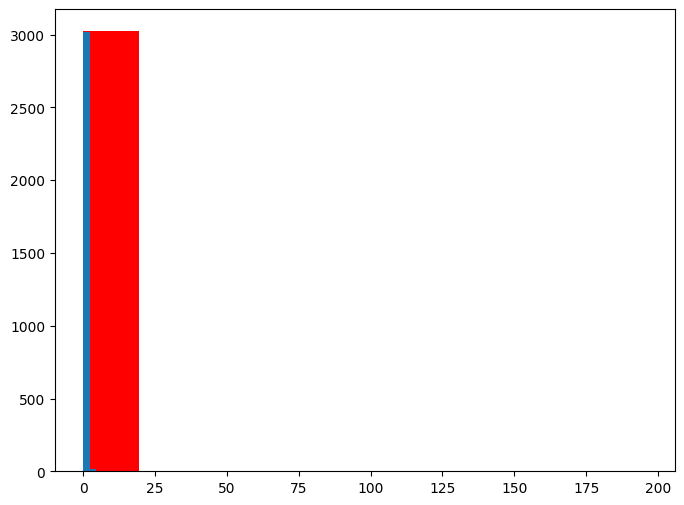

In [78]:
plt.figure(figsize=(8, 6))

plt.hist(a_group.REVENUE, color='r', bins=10)
plt.hist(b_group.REVENUE,  bins=10)


plt.show()

In [79]:
a_group.shape

(3026, 3)

In [80]:
b_group.shape

(3044, 3)

In [81]:
scipy.stats.kstest(a_group[a_group['REVENUE']>0].REVENUE, 'norm')

KstestResult(statistic=0.7117151164389133, pvalue=3.9773520418655274e-28, statistic_location=1.0, statistic_sign=-1)

### Из вывода мы видим, что ***статистика*** теста равна ***0.7117151164389133*** , а соответствующее значение ***p*** равно ***3.9773520418655274e-28***.Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

In [82]:
scipy.stats.kstest(b_group[b_group['REVENUE']>0].REVENUE, 'norm')

KstestResult(statistic=0.7046049359464012, pvalue=5.593497608670862e-22, statistic_location=1.23, statistic_sign=-1)

### Из вывода мы видим, что ***статистика*** теста равна ***0.7046049359464012*** , а соответствующее значение ***p*** равно ***5.593497608670862e-22***.Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

In [83]:
scipy.stats.mannwhitneyu(a_group[a_group['REVENUE']>0].REVENUE, b_group[b_group['REVENUE']>0].REVENUE)

MannwhitneyuResult(statistic=1292.0, pvalue=0.3431833825117172)

## value > 0,05

# Статистически значимых различий между группами нет. Откатываем эксперимент